# **Empathize Stage**
## Data Wrangling and **EDA** Visualization
### **Aavail Project**
Necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from pyampute.exploration.md_patterns import mdPatterns
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.impute import IterativeImputer

sns.set_theme()

In [ ]:
df = pd.read_csv('aavail-data-visualization.csv')
df.head()

,customer_id,country_name,age,customer_name,is_subscriber,subscriber_type,num_streams
0,1,united_states,21.0,Kasen Todd,True,aavail_premium,23.0
1,2,singapore,31.0,Ensley Garza,False,NaN,12.0
2,3,united_states,22.0,Lillian Carey,False,aavail_premium,22.0
3,4,united_states,21.0,Beau Christensen,True,aavail_basic,19.0
4,5,singapore,22.0,Ernesto Gibson,True,aavail_premium,23.0


Presenting the shape and variables details of the data frame.

In [ ]:
print(f'The shape of the DataFrame: {df.shape}')
print('----------')
print(df.info())

The shape of the DataFrame: (1000, 7)
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1000 non-null   int64  
 1   country_name     1000 non-null   object 
 2   age              1000 non-null   float64
 3   customer_name    1000 non-null   object 
 4   is_subscriber    1000 non-null   bool   
 5   subscriber_type  928 non-null    object 
 6   num_streams      954 non-null    float64
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 48.0+ KB
None


We found that there are two variables **subscriber_type, num_streams** with *missing data*.

Check the percentage of missing data in each variables.

In [ ]:
missColumns = ['subscriber_type', 'num_streams']
df[missColumns].isna().mean()

subscriber_type    0.072
num_streams        0.046
dtype: float64

We have less than *10%* of missing value in each variable.

Check the patterns of Missing Data.

In [ ]:
df[missColumns].isna().value_counts()/1000

subscriber_type  num_streams
False            False          0.883
True             False          0.071
False            True           0.045
True             True           0.001
dtype: float64

We found that there is a pattern so we will plot the patterns of Missing Data as a Map, Trying to figure it out.

c:\Users\ASUS\anaconda3\lib\site-packages\pyampute\exploration\md_patterns.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group_values = group_values.append(colsums, ignore_index=True)


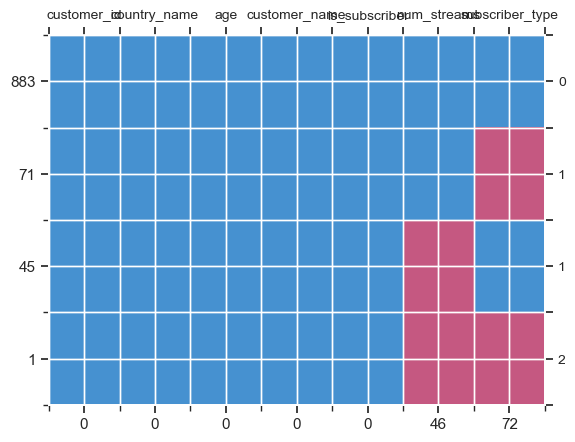

                         row_count  customer_id  country_name  age  \
rows_no_missing                883            1             1    1   
1                               71            1             1    1   
2                               45            1             1    1   
3                                1            1             1    1   
n_missing_values_per_col                      0             0    0   

                          customer_name  is_subscriber  num_streams  \
rows_no_missing                       1              1            1   
1                                     1              1            1   
2                                     1              1            0   
3                                     1              1            0   
n_missing_values_per_col              0              0           46   

                          subscriber_type  n_missing_values  
rows_no_missing                         1                 0  
1                           

In [ ]:
mdp = mdPatterns()
patterns = mdp.get_patterns(df)
print(patterns)

We found that the missing data have pattern that makes us think that the missing data are not *MCAR*

Some Wrangling and Investigations.

**subscriber_type** *vs* **country_name**

In [ ]:
df.groupby(['subscriber_type'], dropna=False)['country_name'].value_counts().to_frame(name = 'Count').tail(2)

Count
subscriber_type country_name        
NaN             united_states     51
                singapore         21

This makes us thick that there is a bias due to **Missing Data**, so let's find the percentage for each one.

[Text(0, 0, '0.07%'), Text(0, 0, '0.073%')]

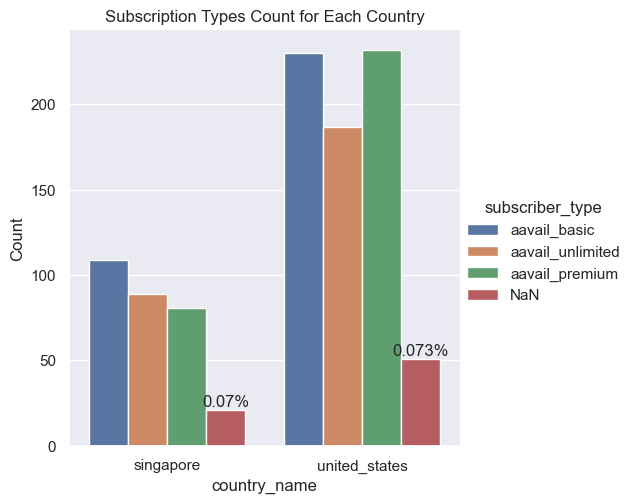

In [ ]:
g = df.groupby(['country_name'])['subscriber_type'].value_counts(dropna=False, ).to_frame(name='Count').reset_index(level = [0,1]).fillna('NaN')

per1 = g.loc[(g['country_name'] == 'singapore') & (g['subscriber_type'] == 'NaN'), 'Count'] / g.loc[g['country_name'] == 'singapore', 'Count'].sum()
per2 = g.loc[(g['country_name'] == 'united_states') & (g['subscriber_type'] == 'NaN'), 'Count'] / g.loc[g['country_name'] == 'united_states', 'Count'].sum()

chart = sns.catplot(data = g, kind = 'bar', x = 'country_name', y = 'Count', hue='subscriber_type')
chart.set(title='Subscription Types Count for Each Country')
ax = chart.facet_axis(0, 0)
c = ax.containers[3]

# labels = [f'{(v.get_height() / 1000):.1f}K' for v in c]
ax.bar_label(c, labels=[str(round(per1.values[0], 3)) + '%', str(round(per2.values[0], 3)) + '%'], label_type='edge')
    

Based on the previous there is no bias based on the **Missing Data**, because the percentages of the missing value are almost the same.

In general there is a bias to **united_states**, so this variable is *unbalanced*.

**subscriber_type** *vs* **is_subscriber**

In [ ]:
df.groupby(['subscriber_type'], dropna=False)['is_subscriber'].value_counts().to_frame(name='Count').tail(2)

Count
subscriber_type is_subscriber       
NaN             True              47
                False             25

[Text(0, 0, '0.066%'), Text(0, 0, '0.087%')]

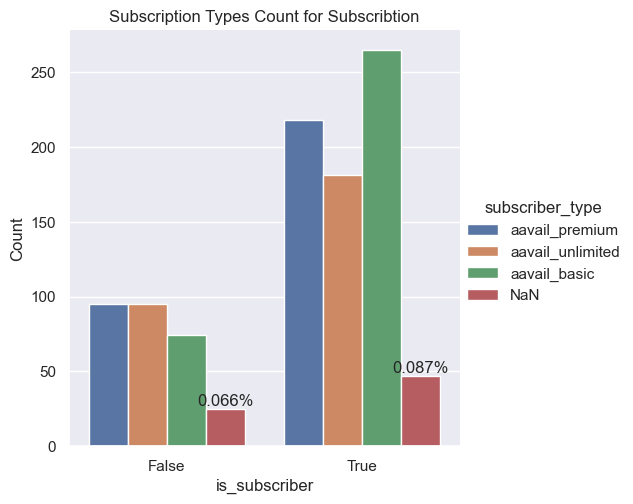

In [ ]:
g = df.groupby(['is_subscriber'])['subscriber_type'].value_counts(dropna = False).to_frame(name='Count').reset_index(level=[0, 1]).fillna('NaN')

per1 = g.loc[(g['is_subscriber'] == True) & (g['subscriber_type'] == 'NaN'), 'Count'].values[0] / g.loc[(g['is_subscriber'] == True), 'Count'].sum()
per2 = g.loc[(g['is_subscriber'] == False) & (g['subscriber_type'] == 'NaN'), 'Count'].values[0] / g.loc[(g['is_subscriber'] == False), 'Count'].sum()

chart = sns.catplot(data = g, kind = 'bar', x = 'is_subscriber', y = 'Count', hue='subscriber_type').set(title='Subscription Types Count for Subscribtion')
ax = chart.facet_axis(0, 0)
c = ax.containers[3]

ax.bar_label(c, labels=[str(round(per1, 3)) + '%', str(round(per2, 3)) + '%'], label_type='edge')



Based on the previous there is no bias based on the **Missing Data**, because the percentages of the missing value are almost the same.

**num_streams** *vs* **country_name**

In [ ]:
df.groupby(['num_streams'], dropna=False)['country_name'].value_counts().to_frame(name = 'Count').tail(2)

Count
num_streams country_name        
NaN         united_states     24
            singapore         22

In [ ]:
per1 = df.loc[(df['country_name'] == 'singapore'), 'num_streams'].isna().sum() / len(df.loc[df['country_name'] == 'singapore'])
per2 = df.loc[(df['country_name'] == 'united_states'), 'num_streams'].isna().sum() / len(df.loc[df['country_name'] == 'united_states'])
print(f'singapore missing num of streams: {round(per1, 3)}')
print(f'united_states missing num of streams: {round(per2, 3)}')

singapore missing num of streams: 0.073
united_states missing num of streams: 0.034


The missing data percentage in **singapore** is more than the percentage in **united_states**, so this difference causes bias to the **united_states** data.

We can see that in the next Histogram.

<Axes: title={'center': 'US'}, ylabel='Frequency'>

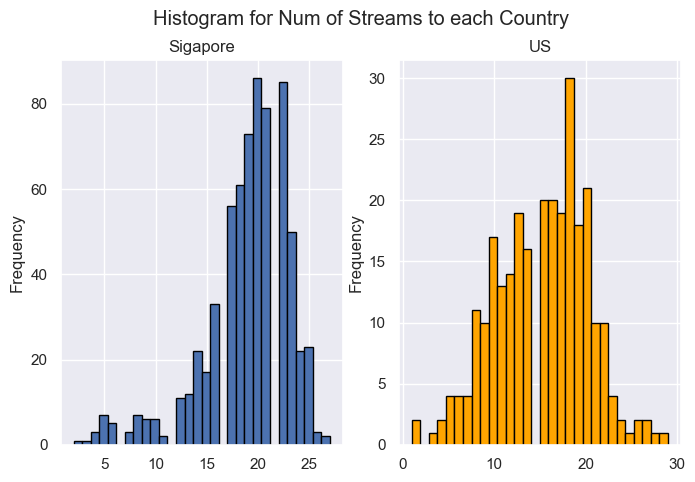

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(8,5))
figure.suptitle('Histogram for Num of Streams to each Country')
axes[0].set_title('Sigapore')
axes[1].set_title('US')

df.loc[(df['country_name'] == 'united_states'), 'num_streams'].plot(kind='hist', bins = 30, ec='black', ax = axes[0])
df.loc[(df['country_name'] == 'singapore'), 'num_streams'].plot(kind='hist', bins = 30, ec='black', color = 'orange', ax = axes[1])

<Axes: title={'center': 'Number of Streams'}, ylabel='Frequency'>

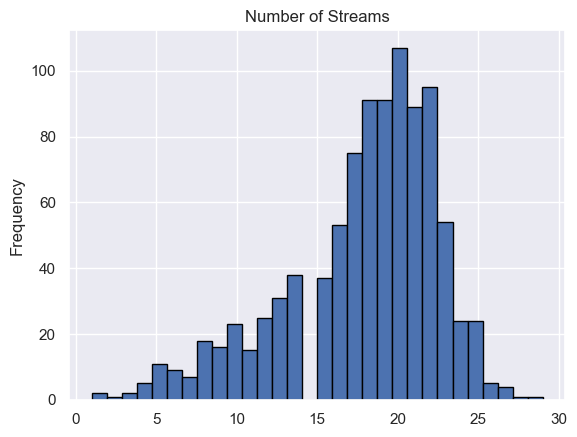

In [ ]:
df['num_streams'].plot(kind='hist', bins = 30, ec='black', title='Number of Streams')

**num_streams** *vs* **is_subscriber**

In [ ]:
df.groupby(['num_streams'], dropna=False)['is_subscriber'].value_counts().to_frame(name='Count').tail(2)

Count
num_streams is_subscriber       
NaN         True              32
            False             14

In [ ]:
per1 = df.loc[(df['is_subscriber'] == True), 'num_streams'].isna().sum() / len(df.loc[df['is_subscriber'] == True])
per2 = df.loc[(df['is_subscriber'] == False), 'num_streams'].isna().sum() / len(df.loc[df['is_subscriber'] == False])
print(f'Subscribers missing num of streams: {round(per1, 3)}')
print(f'Not Subscribers missing num of streams: {round(per2, 3)}')

Subscribers missing num of streams: 0.045
Not Subscribers missing num of streams: 0.048


The Percentage are almost equals so we can say that there is no bias based to the subscribers.

The following is a Histogram for Num of Streams for those who subscribed or not. 

<Axes: title={'center': 'No'}, ylabel='Frequency'>

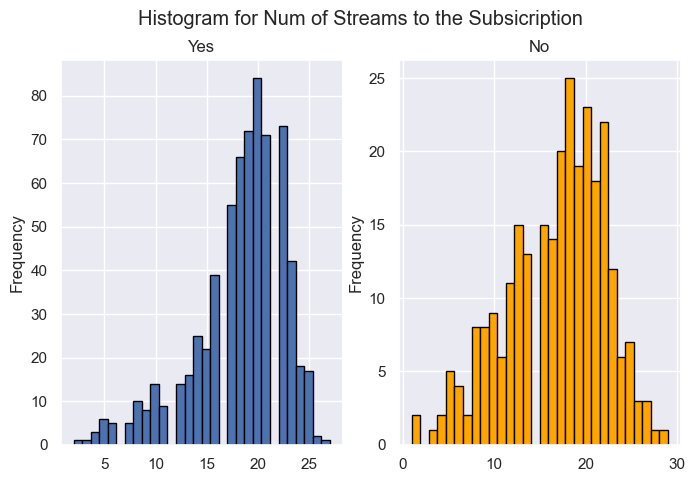

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(8,5))
figure.suptitle('Histogram for Num of Streams to the Subsicription')
axes[0].set_title('Yes')
axes[1].set_title('No')

df.loc[(df['is_subscriber'] == True), 'num_streams'].plot(kind='hist', bins = 30, ec='black', ax = axes[0])
df.loc[(df['is_subscriber'] == False), 'num_streams'].plot(kind='hist', bins = 30, ec='black', color = 'orange', ax = axes[1])

We will moving now to Hypotheses Testing, Starting by do *MCAR test* to the **age** and **num_streams**, with the following state of hypothesis:

* $H\_0: **age** and **num_streams** are independent so there is no relation between them that effect the missing data.
* $H\_1: They are not.

In [ ]:
mt = MCARTest()
value = mt.little_mcar_test( df[['age', 'num_streams']] )
print(f'P-Value: {value}')

P-Value: 1.8831016136644507e-05


Based on the P-value we can reject the Null Hypothesis.

state of Hypothesis for **subscriber_type** and **country_name**:

* $H\_0: **subscriber_type** and **country_name** are independent so there is no relation between them that effect the missing data.
* $H\_1: They are not.

In [ ]:
cc = pd.crosstab(df['subscriber_type'].fillna('missing'), df['country_name'],)
value = stats.chi2_contingency(cc)
print(f'P-Value: {value[1]}')

P-Value: 0.26501615774613035


Based on the P-value we can not reject the Null Hypothesis.

state of Hypothesis for **subscriber_type** and **age**:
* $H\_0: **subscriber_type** and **age** are independent so there is no relation between them that effect the missing data.
* $H\_1: They are not.

In [ ]:
dfTemp = df[['subscriber_type', 'age']]
dfTemp = dfTemp.fillna('missing')

stats.levene(dfTemp.loc[dfTemp['subscriber_type'] == 'aavail_basic']['age'],
            dfTemp.loc[dfTemp['subscriber_type'] == 'aavail_premium']['age'],
            dfTemp.loc[dfTemp['subscriber_type'] == 'aavail_unlimited']['age'],
            dfTemp.loc[dfTemp['subscriber_type'] == 'missing']['age'],
            center = 'mean')

LeveneResult(statistic=2.070637064929318, pvalue=0.10246646882191954)

The groups do not have an equal varience so we can not use *ANOVA*, and instead we will use *Kruskal* which does not have problems with the varience issue.

In [ ]:
dfTemp = df[['subscriber_type', 'age']]
dfTemp = dfTemp.fillna('missing')

stats.kruskal(dfTemp.loc[dfTemp['subscriber_type'] == 'aavail_basic']['age'],
            dfTemp.loc[dfTemp['subscriber_type'] == 'aavail_premium']['age'],
            dfTemp.loc[dfTemp['subscriber_type'] == 'aavail_unlimited']['age'],
            dfTemp.loc[dfTemp['subscriber_type'] == 'missing']['age'],)

KruskalResult(statistic=3.9345817178236597, pvalue=0.2686153201366135)

Based on the P-value we can not reject the Null Hypothesis.

In [ ]:
scp.levene(
    df.dropna().loc[df['is_subscriber'] == True]['num_streams'],
    df.dropna().loc[df['is_subscriber'] == False]['num_streams'], center='mean'
)

LeveneResult(statistic=20.34474076947048, pvalue=7.341996421949922e-06)

In [ ]:
scp.f_oneway(
    df.dropna().loc[df['is_subscriber'] == True]['num_streams'],
    df.dropna().loc[df['is_subscriber'] == False]['num_streams'], 
)

F_onewayResult(statistic=19.64331883211847, pvalue=1.0509358853845736e-05)

In [ ]:
scp.levene(
            df.dropna().loc[df['subscriber_type'] == 'aavail_basic']['num_streams'],
            df.dropna().loc[df['subscriber_type'] == 'aavail_premium']['num_streams'],
            df.dropna().loc[df['subscriber_type'] == 'aavail_unlimited']['num_streams'], center='mean'
)

LeveneResult(statistic=13.216481438425454, pvalue=2.2114235890901506e-06)

In [ ]:
scp.f_oneway(
                df.dropna().loc[df['subscriber_type'] == 'aavail_basic']['num_streams'],
            df.dropna().loc[df['subscriber_type'] == 'aavail_premium']['num_streams'],
            df.dropna().loc[df['subscriber_type'] == 'aavail_unlimited']['num_streams'],
)

F_onewayResult(statistic=1.6117134385494494, pvalue=0.2001338700648013)

In [ ]:
scp.levene(
            df.dropna().loc[df['country_name'] == 'singapore']['num_streams'],
            df.dropna().loc[df['country_name'] == 'united_states']['num_streams'], center='mean'
)

LeveneResult(statistic=21.083186117667363, pvalue=5.0372487417334555e-06)

In [ ]:
scp.f_oneway(
                df.dropna().loc[df['country_name'] == 'singapore']['num_streams'],
            df.dropna().loc[df['country_name'] == 'united_states']['num_streams'], 

)

F_onewayResult(statistic=135.35918442184692, pvalue=3.3231749460711966e-29)

Based on the previous we can say that the missing data type is not **MCAR** and it is almost **MNAR** for **num_streams** variable, and it's **MAR** for **subscriber_type** variable.

Impute **subcriber_type** missing data:

Based on the previous studies we will impute the missing data by sampling from the existense data, because our Missing Data are **MAR** and it's not related to the other features, at the same time it's mode is not make sense to use it because it's almost the same as the others.  

In [ ]:
mask = df['subscriber_type'].isna()
temp = df.loc[~mask, ['subscriber_type']].sample(72)['subscriber_type'].values
df.loc[mask, ['subscriber_type']] = temp
df.loc[mask, ['subscriber_type']].head()


,subscriber_type
1,aavail_unlimited
17,aavail_basic
51,aavail_premium
74,aavail_premium
75,aavail_unlimited


In [ ]:
df['subscriber_type'].value_counts()

aavail_basic        372
aavail_premium      331
aavail_unlimited    297
Name: subscriber_type, dtype: int64

Results: Now we cleared the **subscriber_type** feature from missing data problem.

Impute **num_streams** missing data:

We found in the previous studies that the missing data in **num_streams** feature are **MNAR**, and it's relate to the other features, so we need a model to impute it, and we choose *IterativeImputer* with *BayesianRidge* estimator which is the default option.

In [ ]:
df_impute = pd.concat([df.drop(columns=['country_name']), pd.get_dummies(df['country_name'])], axis=1)
imp_num_fet = ['singapore', 'united_states', 'age', 'is_subscriber', 'num_streams']
imputed = IterativeImputer().fit_transform(df_impute[imp_num_fet])
num_streams = imputed[:,4].round()

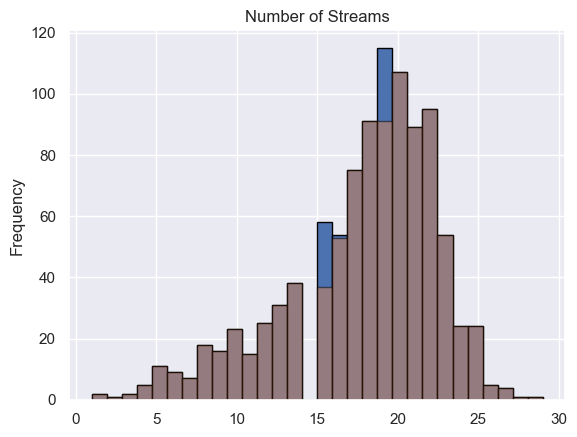

In [ ]:
df['imputed'] = num_streams
df['imputed'].plot(kind='hist', bins = 30, ec = 'black', title='imputated')
df['num_streams'].plot(kind='hist', bins = 30, ec='black', title='Number of Streams', alpha=.5)
df['num_streams'] = num_streams
df.drop(columns=['imputed'], inplace = True)

Results: we tried more than one model and the results was the almost the same, now the **num_streams** feature is clear from missing data problem.

### EDA
#### Visualization

Box Plots for [ **age** | **num_streams** ] grouped by **country_name**

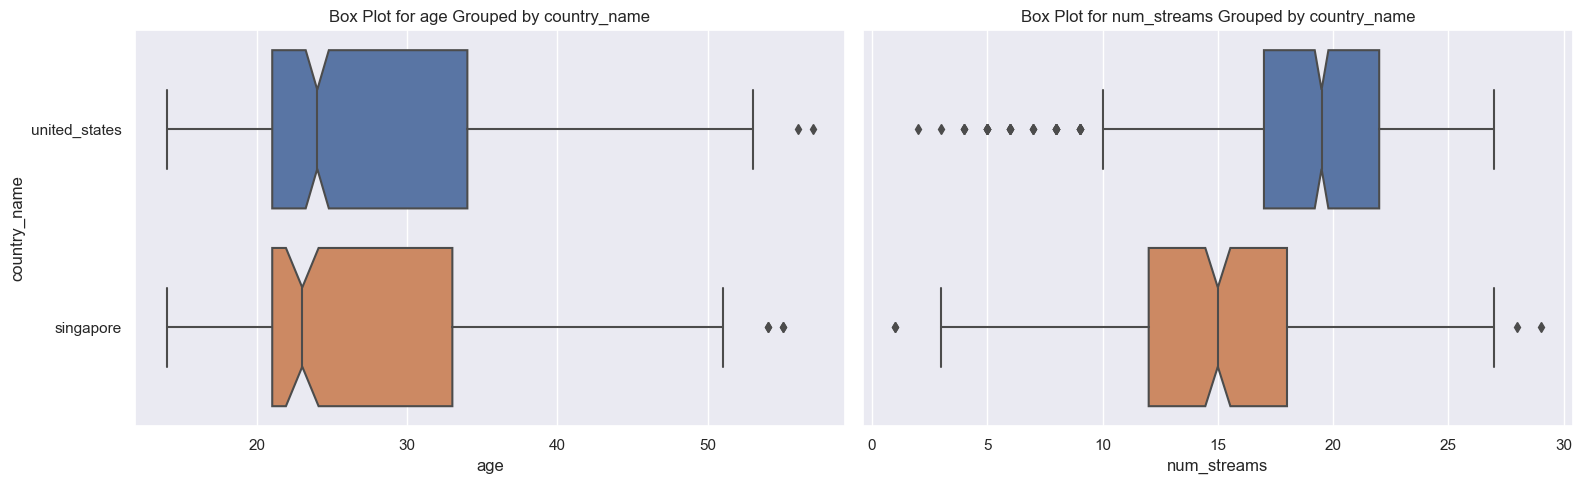

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(16, 5), sharey = True)
box1 = sns.boxplot(df, x = 'age', y = 'country_name' ,notch=True, orient="h", ax= axis[0])
box1.set_title("Box Plot for age Grouped by country_name")

box2 = sns.boxplot(df, x = 'num_streams', y = 'country_name', notch = True, orient = 'h', ax = axis[1])
box2.set_title('Box Plot for num_streams Grouped by country_name')
box2.set_ylabel(None)
plt.tight_layout()


Results: 

* For **age**: we found that there is no difference between the distributions for each country, and there is bias to the left.
* For **num_streams**: we found that there is difference between the distributions and the *united_states*'s is higher. 

Bar Plots for [ **subscriber_type** | **is_subcriber** ] counts grouped by **country_name**

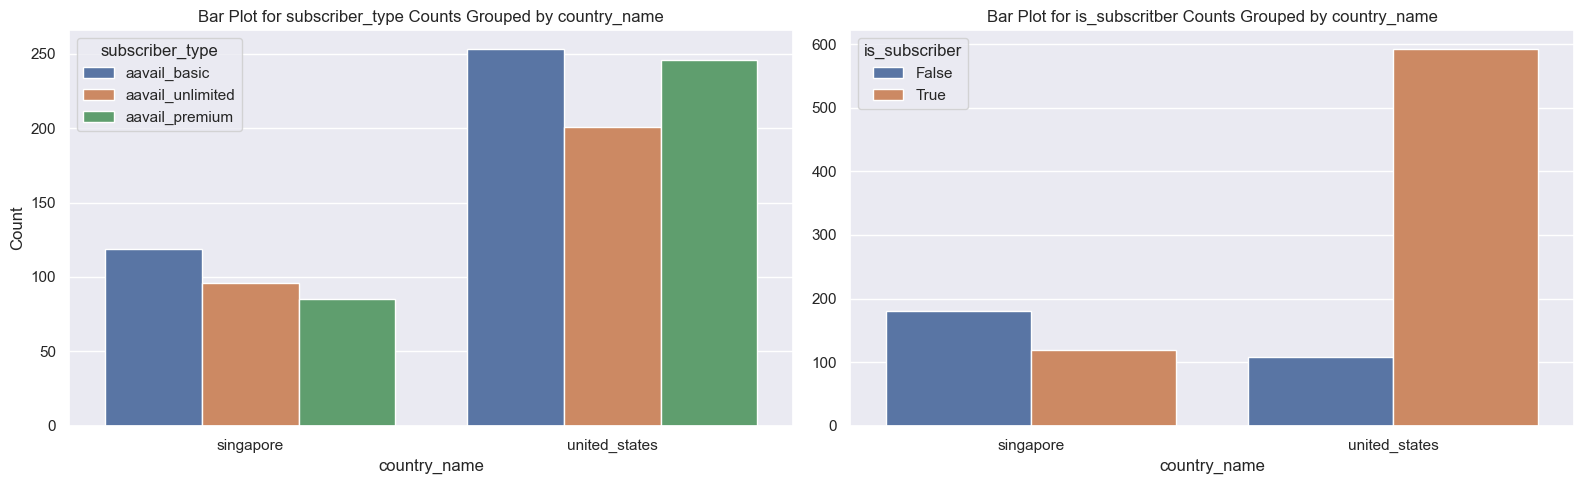

In [ ]:
g = df.groupby(['country_name'])['subscriber_type'].value_counts().to_frame(name='Count').reset_index(level=[0,1])
figure, axis = plt.subplots(1, 2, figsize=(16, 5))
bar1 = sns.barplot(g, x = 'country_name', y = 'Count', hue='subscriber_type', ax = axis[0])
bar1.set_title('Bar Plot for subscriber_type Counts Grouped by country_name')

g = df.groupby(['country_name'])['is_subscriber'].value_counts().to_frame(name='Count').reset_index(level=[0,1])

bar2 = sns.barplot(g, x = 'country_name', y = 'Count', hue = 'is_subscriber', ax = axis[1])
bar2.set_title('Bar Plot for is_subscritber Counts Grouped by country_name')
bar2.set_ylabel(None)

plt.tight_layout()

Results:

* For **subscriber_type**: we found that it's almost the same for each country, but *united_states* has more customer than *singapore* by far.
* For **is_subscriber**: we found that in *singapore* the non-subscribers are more than subscribers, but for *united_states* subscribers are the more by far and the number of Non-subscribers are less than the Non-subscribers in *singapore*.  

Bar Plot for **subscriber_type** counts grouped by **is_subscriber**

Text(0.5, 1.0, 'Bar Plot for subscriber_type Counts Groubed by is_subscriber')

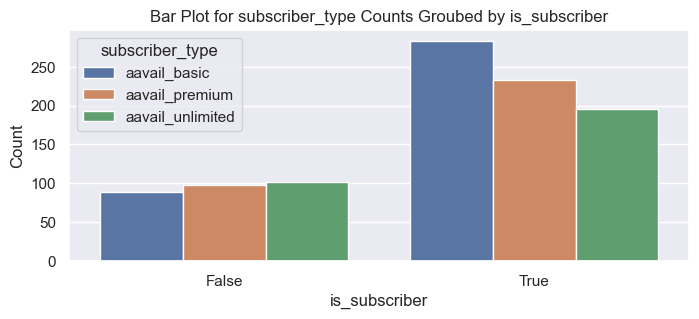

In [ ]:
g = df.groupby(['subscriber_type'])['is_subscriber'].value_counts().to_frame(name='Count').reset_index(level = [0, 1])

plt.figure(figsize = (8, 3))
bar1 = sns.barplot(g, x = 'is_subscriber', y = 'Count', hue='subscriber_type')
bar1.set_title('Bar Plot for subscriber_type Counts Groubed by is_subscriber')

Results:

* Based on the **subscriber_type** the Non-subscribers count are almost the same.

Box Plots for [ **age** | **num_streams** ] grouped by subscriber_type

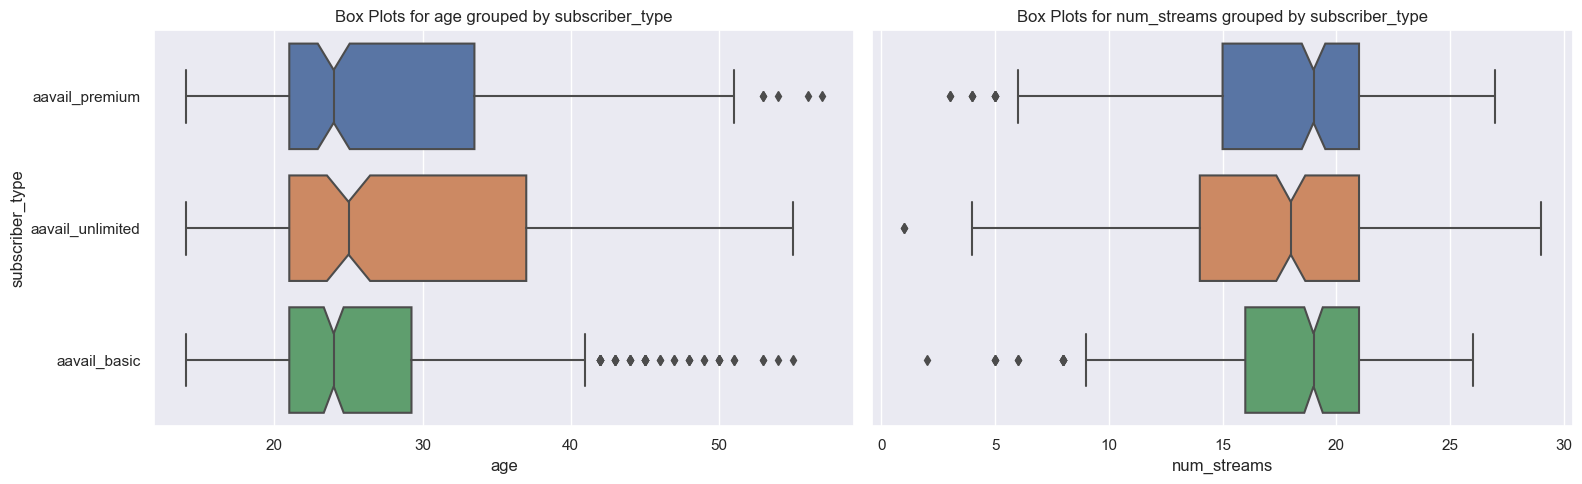

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(16, 5), sharey = True)
box1 = sns.boxplot(df, x = 'age', y = 'subscriber_type' ,notch=True, orient="h", ax= axis[0])
box1.set_title("Box Plots for age grouped by subscriber_type")

box2 = sns.boxplot(df, x = 'num_streams', y = 'subscriber_type', notch = True, orient = 'h', ax = axis[1])
box2.set_title('Box Plots for num_streams grouped by subscriber_type')
box2.set_ylabel(None)
plt.tight_layout()


Results:

* For **age**: the distributions has almost the same midians, just the unlimited type has bigger distribution, and it is skewed to the left.
* For **num_streams**: they all similar, with a little bit difference with the median in the unlimited type.  

Box Plots for [ **age** | **num_streams** ] grouped by **country_name**, grouped by ***subscriber_type**

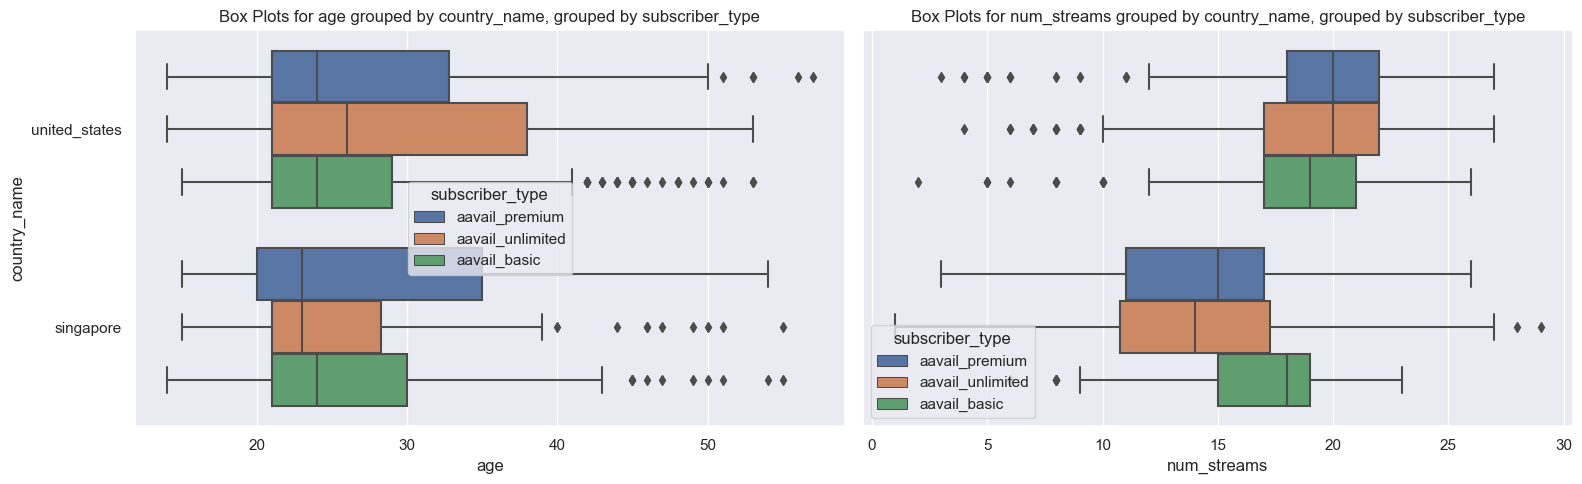

In [ ]:
figure, axis = plt.subplots(1, 2, figsize = (16, 5), sharey = True)
box1 = sns.boxplot(df, y = 'country_name', x = 'age', hue='subscriber_type', ax=axis[0])
box1.set_title('Box Plots for age grouped by country_name, grouped by subscriber_type')

box2 = sns.boxplot(df, y = 'country_name', x = 'num_streams', hue='subscriber_type', ax=axis[1])
box2.set_title('Box Plots for num_streams grouped by country_name, grouped by subscriber_type')
box2.set_ylabel(None)

plt.tight_layout()

Results:

* For **age** and *united_states*: the unlimited type has bigger distribgution, but they all have almost the same midian.
* For **age** and *singapore*: the preimium type has the bigger distribution then the basic and the last one is the unlimited, and they all have similar midians.
* For **num_streams** and *united_states*: they almsot similar, the preimium type has bigger midian.
* For **num_streams** and *singapore*: there is difference between types, the basic type has smaller distribution but higher values and higher midian.  

Scatter Plots for [ **age** | **num_streams** ] vs **subscriber_type** separated by **is_subscriber**

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 16.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 16.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 27.4% of the points canno

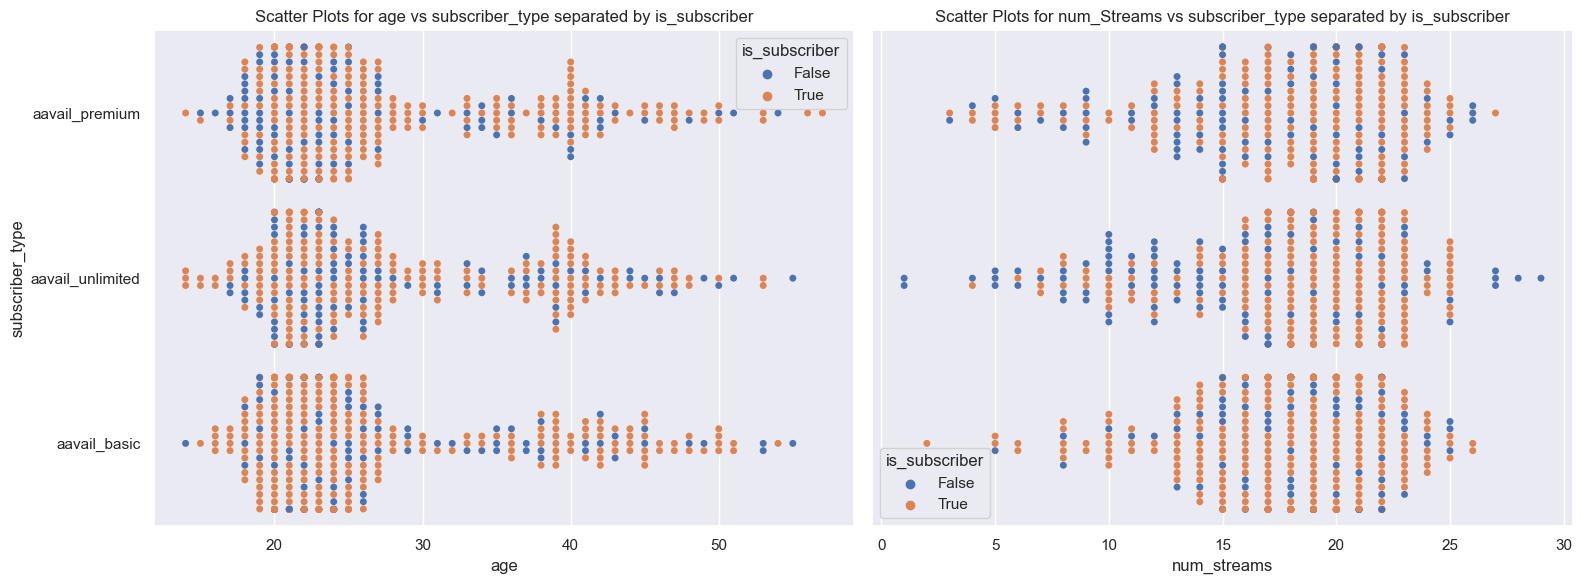

In [ ]:
figure, axis = plt.subplots(1, 2,figsize = (16, 6), sharey = True)

sca1 = sns.swarmplot( data=df, x = 'age', y = 'subscriber_type', hue = 'is_subscriber', ax = axis[0])
sca1.set_title('Scatter Plots for age vs subscriber_type separated by is_subscriber')

sca2 = sns.swarmplot(data = df, x = 'num_streams', y = 'subscriber_type', hue = 'is_subscriber', ax = axis[1])
sca2.set_title('Scatter Plots for num_Streams vs subscriber_type separated by is_subscriber')
sca2.set_ylabel(None)

plt.tight_layout()

Results:

* For **age**: we found that the Non-subscribers with preimium type are centered around the age of 20, and around 23 with the unlimited type.
* For **num_streams**: we found that people with higher and lower number of streams have the highest number of Non-subscribers. 

Scatter and density Plots for **age** vs **num_streams** separated by **is_subscriber**

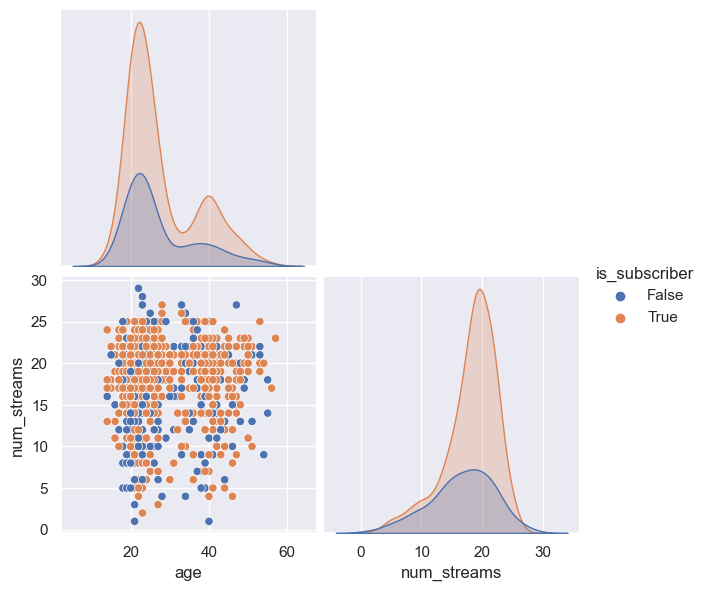

In [ ]:
sns.pairplot(df[['age', 'num_streams', 'is_subscriber']], hue='is_subscriber', corner=True, height=3)

Results:

* There is no clear relation between **age** and **num_streams**. 

Box Plot for **num_streams** grouped by **is_subscriber**

Text(0.5, 1.0, 'Box Plot for num_streams Grouped by is_subscriber')

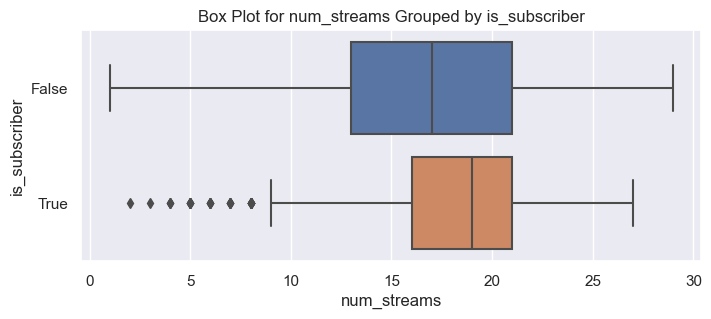

In [ ]:
plt.figure(figsize=(8, 3))
box = sns.boxplot(data=df, x = 'num_streams', y = 'is_subscriber', orient='h')
box.set_title('Box Plot for num_streams Grouped by is_subscriber')

Results:

* Non_subscribers have bigger distribution than subscribers, but the median is lower.